Cette page doit être lancée sur Kaggle, depuis la compétition pour avoir accès aux données. Sinon vous devez récupérer les données séparément.

In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import FileLink
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = '/kaggle/working/outputs'

In [2]:
!mkdir /kaggle/working/outputs

## Lire les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [3]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data"
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(directory_path, labels='inferred',subset='both',shuffle=True,validation_split=0.2,seed=SEED,image_size=(16,24))


Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Using 7103 files for validation.


In [4]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

In [5]:
class CheckValidationLossCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=0):
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        if val_loss < train_loss:
            self.counter = 0
            print(f"\nValidation loss ({val_loss:.4f}) is less than training loss ({train_loss:.4f})")
        else:
            self.counter +=1
            
        if(self.counter == self.patience):
            self.model.stop_training = True

In [6]:
def test_phase(model):
    file_name = f'submission.csv'
    X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
    X_test = X_test.astype('float32')
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv(os.path.join(OUTPUT_DIR,file_name), index_label="Id")

def save_history(model,history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history_{model.name}.csv"
    history_df.to_csv(os.path.join(OUTPUT_DIR,hist_file_name))

def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(OUTPUT_DIR,model_file_name))

In [28]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, MaxPooling2D, Dropout,Flatten, Dense, BatchNormalization, Rescaling
from tensorflow.keras.models import load_model
def build_model() -> Model:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(16, 24, 3)),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.1),
         tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(256, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
    return model
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 14, 22, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 11, 64)        0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 7, 11, 64)         0         
                                                                 
 batch_normalization_19 (Bat  (None, 7, 11, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 11, 128)        73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 3, 5, 128)       

Epoch 1/75


2023-05-13 22:00:15.173343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


888/888 [==============================] - 18s 17ms/step - loss: 1.9183 - accuracy: 0.3684 - val_loss: 1.5206 - val_accuracy: 0.4645
Epoch 2/75
888/888 [==============================] - 15s 17ms/step - loss: 1.4819 - accuracy: 0.4918 - val_loss: 1.5830 - val_accuracy: 0.4609
Epoch 3/75
888/888 [==============================] - 15s 17ms/step - loss: 1.3507 - accuracy: 0.5361 - val_loss: 1.2500 - val_accuracy: 0.5665
Epoch 4/75
888/888 [==============================] - 15s 17ms/step - loss: 1.2746 - accuracy: 0.5583 - val_loss: 1.1985 - val_accuracy: 0.5813
Epoch 5/75
888/888 [==============================] - 16s 18ms/step - loss: 1.2156 - accuracy: 0.5825 - val_loss: 1.2188 - val_accuracy: 0.5781
Epoch 6/75
888/888 [==============================] - 16s 17ms/step - loss: 1.1479 - accuracy: 0.6068 - val_loss: 1.4104 - val_accuracy: 0.5085
Epoch 7/75
888/888 [==============================] - 16s 18ms/step - loss: 1.0977 - accuracy: 0.6180 - val_loss: 1.0901 - val_accuracy: 0.6273
Epo

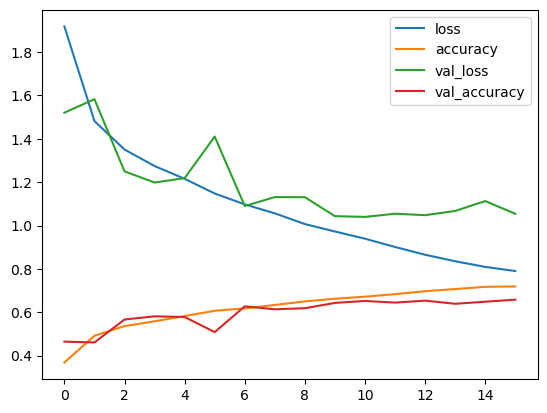

In [29]:
def train_and_test(epochs=50,model=None):
    callbacks = []
    #callbacks.append(CheckValidationLossCallback(patience=3))
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
    if model is None:
        model = build_model() 
    history = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=callbacks,batch_size = 200)
    test_phase(model)
    save_model(model)
    save_history(model,history)
    return history

#model = load_model('/kaggle/input/model-bast/sequential_18.h5')
history = train_and_test(epochs=75,model=model)
test_phase(model)
save_model(model)

pd.DataFrame(history.history).plot()
plt.show()

116/116 [==============================] - 0s 3ms/step


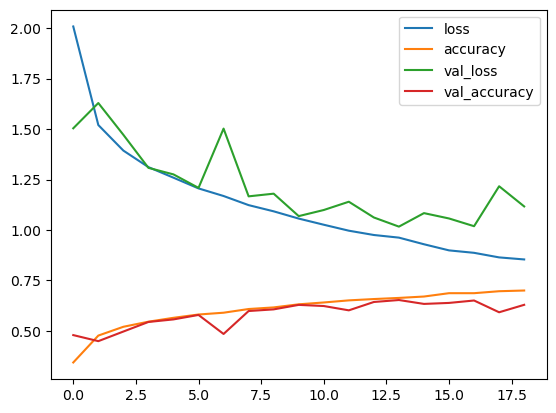

In [ ]:
!rm -rf ships32/

In [ ]:
print("Nombre de couches : ", len(model.layers))